In [1]:
# External library
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt

# Local library
from dataset import DataSet
import transformer as tfr
import seq2seq as s2s

/Users/yujl/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Prepare Translation DataSet

## (1) Tatoeba

In [2]:
# Read file and create dataset
data = DataSet(max_length=16)
data.read_file('./data/fra.txt')

Total number of samples: 229803


In [3]:
sample, sample_dec = data.tokenize()

In [4]:
print(sample['input_ids'][0])
print(sample['labels'][0])
print(sample_dec[0])
print(data.tokenizer.decode(sample['labels'][0], skip_special_tokens=True))

tensor([  631,   250,     0, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
        59513, 59513, 59513, 59513, 59513, 59513])
tensor([  740,   291,     0, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
        59513, 59513, 59513, 59513, 59513, 59513])
tensor([    0,   740,   291,     0, 59513, 59513, 59513, 59513, 59513, 59513,
        59513, 59513, 59513, 59513, 59513, 59513])
va!


## (2) Ted talks

In [27]:
data_ted = DataSet(max_length=16)

In [28]:
data_ted.read_xml('./data/IWSLT17.TED.tst2017.en-fr.en.xml', './data/IWSLT17.TED.tst2017.fr-en.fr.xml')

Total number of source samples: 1455
Total number of targetsamples: 1455


In [29]:
sample_ted, sample_ted_dec = data_ted.tokenize()

In [30]:
print(sample_ted['input_ids'][0])
print(sample_ted['labels'][0])
print(sample_ted_dec[0])
print(data_ted.tokenizer.decode(sample_ted['labels'][0], skip_special_tokens=True))

tensor([  89,    6,   82,   38,  179,   75, 4646,   17, 1057, 3950,    5, 1027,
          30,  146,  567,    0])
tensor([  752,     2,    67,    32,    15,    62, 13801,    15, 15402,    49,
         9868,    49,  3148,  2635, 12588,     0])
tensor([    0,   752,     2,    67,    32,    15,    62, 13801,    15, 15402,
           49,  9868,    49,  3148,  2635, 12588])
So, this is a story about how we know


So now we can treat both dataset in the same way.

In [5]:
tensors = list()
for i in tqdm(range(len(sample_dec))):
    input_ids  = sample['input_ids'][i]
    valid_lens = sample['attention_mask'][i].sum()
    labels     = sample['labels'][i]
    dec_inputs = sample_dec[i]
# for i in tqdm(range(len(sample_ted_dec))):
#     input_ids  = sample_ted['input_ids'][i]
#     valid_lens = sample_ted['attention_mask'][i].sum()
#     labels     = sample_ted['labels'][i]
#     dec_inputs = sample_ted_dec[i]
    tensors.append((input_ids, dec_inputs, valid_lens, labels))

  0%|          | 0/229803 [00:00<?, ?it/s]

In [6]:
train_dataloader = DataLoader(tensors[:512], batch_size=128, shuffle=False)

for batch in train_dataloader:
    enc_inputs, dec_inputs, valid_lens, labels = batch
    print(enc_inputs.shape)
    print(dec_inputs.shape)
    print(valid_lens.shape)
    print(labels.shape)
    break

torch.Size([128, 16])
torch.Size([128, 16])
torch.Size([128])
torch.Size([128, 16])


# Create NMT model

In [8]:
# Create transformer Seq2Seq model
# input parameters of encoder and decoder
# (vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, use_bias=False)
# vocab_size  = data_ted.vocab_size
vocab_size  = data.vocab_size
num_hiddens = 256
ffn_hiddens = 64
num_heads   = 4
num_blks    = 2
dropout     = 0.2

# Use transformer encoder/decoder. Can also use GRU encoder/decoder
encoder = tfr.TransformerEncoder(vocab_size, num_hiddens, ffn_hiddens, num_heads, num_blks, dropout)
decoder = tfr.TransformerDecoder(vocab_size, num_hiddens, ffn_hiddens, num_heads, num_blks, dropout)

# Seq2Seq model
padding_index = data.tokenizer.pad_token_id
# padding_index = data_ted.tokenizer.pad_token_id
lr = 1e-3

model = s2s.Seq2Seq(encoder, decoder, padding_index, lr)

/Users/yujl/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
## Create GRU Seq2Seq model
# vocab_size  = data_ted.vocab_size
vocab_size  = data.vocab_size
embed_size = 256
num_hiddens = 256
num_layers = 2
dropout = 0.2

encoder = s2s.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers, dropout)
decoder = s2s.Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers, dropout)

# padding_index = data_ted.tokenizer.pad_token_id
padding_index = data.tokenizer.pad_token_id
lr = 1e-3

model = s2s.Seq2Seq(encoder, decoder, padding_index, lr)

/Users/yujl/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Training our NMT models

In [10]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)

epochs = 30

# Use wandb to monitor the model

cpu


In [11]:
losses = list()

model.to(device)
model.train()
for epoch in trange(epochs):
    for batch in tqdm(train_dataloader):
        a, b, c, d = batch
        enc_inputs = a.to(device)
        dec_inputs = b.to(device)
        valid_lens = c.to(device)
        labels     = d.to(device)
        
        Y_hat = model(enc_inputs, dec_inputs, valid_lens)
        
        loss = model.loss(Y_hat.transpose(1, 2), labels)
        
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        
        losses.append(loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

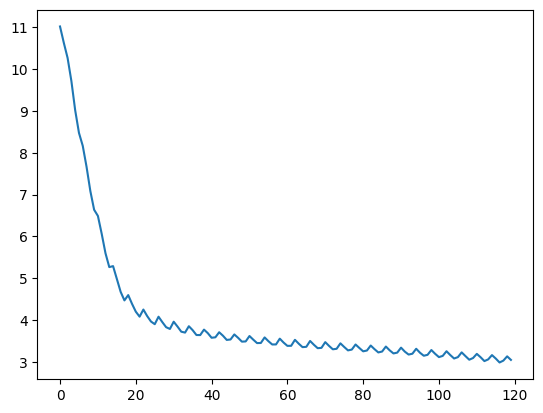

In [12]:
plt.plot(losses)

# Create a SMT (Statistical Machine Translation) model as baseline

In [13]:
import nltk
nltk.download('swadesh')
from nltk.corpus import swadesh
en2fr = [ (i.lower(), j.lower()) for i, j in swadesh.entries(['en', 'fr'])]
translation_dict = dict(en2fr)

[nltk_data] Downloading package swadesh to /Users/yujl/nltk_data...
[nltk_data]   Package swadesh is already up-to-date!


In [14]:
def translate_sentence(sentence):
    """
    Translate a sentence using the translation dictionary.
    
    Args:
    sentence (str): Input sentence in English.
    
    Returns:
    str: Translated sentence in French.
    """
    # Tokenize the input sentence
    tokens = sentence.lower().split()
    
    # Translate each token using the dictionary, if available
    translated_tokens = [translation_dict.get(token, token) for token in tokens]
    
    # Join the translated tokens to form the translated sentence
    translated_sentence = ' '.join(translated_tokens)
    
    return translated_sentence

# Example usage
english_sentence = "far ."
french_translation = translate_sentence(english_sentence)
print("English:", english_sentence)
print("French:", french_translation)

English: far .
French: loin .


# Evaluation of different models

## (1) BLEU

In [15]:
test_dataloader = DataLoader(tensors[10000:10000+512], batch_size=4, shuffle=True)

In [16]:
model.to(device)
for batch in test_dataloader:

    preds, _ = model.predict_step(batch, device, data.max_length)
    engs = [data.tokenizer.convert_ids_to_tokens(batch[0][i], skip_special_tokens=True) for i in range(4)]
    fras = [data.tokenizer.convert_ids_to_tokens(batch[3][i], skip_special_tokens=True) for i in range(4)]
    
    for en, fr, p in zip(engs, fras, preds):
        translation = []
        for token in data.tokenizer.convert_ids_to_tokens(p):
            if token == '</s>':
                break
            translation.append(token)
        str_en = data.tokenizer.convert_tokens_to_string(en)
        str_fr = data.tokenizer.convert_tokens_to_string(fr)
        print(f'{str_en} => {str_fr}, bleu,'
              f'{s2s.bleu(translation, fr, k=2):.3f}')
        print(f'{str_en} => {translate_sentence(str_en)}, bleu,'
              f'{s2s.bleu(translate_sentence(str_en), fr, k=2):.3f}')

    break

you're a liar . => tu es un menteur ., bleu,0.000
you're a liar . => you're a liar ., bleu,0.000
you're grumpy . => vous êtes bougonne ., bleu,0.000
you're grumpy . => you're grumpy ., bleu,0.000
bring the kids . => amène les enfants ., bleu,0.000
bring the kids . => bring the kids ., bleu,0.000
you're my age . => vous avez le même âge que moi ., bleu,0.000
you're my age . => you're my age ., bleu,0.000


In [17]:
fras = [5682, 21, 2137, 19, 6381, 21, 682, 291, 0,]
engs = [631, 250, 0, 59513]
print(data.tokenizer.convert_tokens_to_string(data.tokenizer.convert_ids_to_tokens(engs)))
print(data.tokenizer.convert_ids_to_tokens(fras))
print(data.tokenizer.decode(fras))
print(data.tokenizer.convert_tokens_to_string(data.tokenizer.convert_ids_to_tokens(fras)))

go .</s> <pad>
['▁allez', '-', 'nous', '▁le', '▁laisse', '-', 'vous', '▁!', '</s>']
allez-nous le laisse-vous!</s>
allez-nous le laisse-vous !</s>


In [18]:
s2s.bleu("a b c d e", "a b c e f", k=2)

0.8773826753016616

## (2) chrF